In [1]:
import re
import string
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from urllib.parse import urlparse
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier, Perceptron
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from tldextract import extract as tld_extract
from tld import get_tld, is_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError

from colorama import Fore
from datetime import datetime
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from wordcloud import WordCloud
from gensim.models import Word2Vec
import tldextract
import hashlib
import whois
import warnings

warnings.filterwarnings("ignore")
print('Hello')

Hello


In [2]:
urls_data = pd.read_csv('D:\\Phuong - Mobifone R&D\\1. DE TAI -SANG KIEN\\DE TAI\\2. De tai 2023\\2. Phising system\\dataset\\URL\\malicious_phish.csv')
urls_data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [3]:
urls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [4]:
urls_data.isnull().sum()

url     0
type    0
dtype: int64

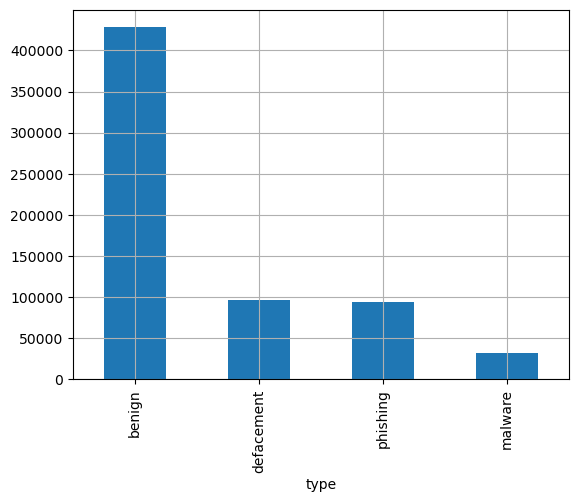

In [5]:
urls_data['type'].value_counts().plot(kind='bar')
plt.grid(True)

In [6]:
urls_data['url'] = urls_data['url'].replace('www.', '', regex=True)
urls_data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [7]:
dict1={'benign':0, 'defacement':1, 'phishing':2, 'malware':3}
urls_data['typeid']=urls_data['type'].replace(dict1)
urls_data.head()

,url,type,typeid
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [8]:
def get_url_length(url):
    # Remove common prefixes
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        if url.startswith(prefix):
            url = url[len(prefix):]

    # Remove 'www.' if present
    url = url.replace('www.', '')

    # Return the length of the remaining URL
    return len(url)
urls_data['url_len'] = urls_data['url'].apply(lambda x: get_url_length(str(x)))
urls_data.head()

,url,type,typeid,url_len
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228


In [9]:
def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain
urls_data['pri_domain'] = urls_data['url'].apply(lambda x: extract_pri_domain(x))
urls_data.head()

,url,type,typeid,url_len,pri_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net


In [10]:
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits

def count_special_chars(url):
    special_chars = set(string.punctuation)
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars

urls_data['letters_count']        = urls_data['url'].apply(lambda x: count_letters(x))
urls_data['digits_count']         = urls_data['url'].apply(lambda x: count_digits(x))
urls_data['special_chars_count']  = urls_data['url'].apply(lambda x: count_special_chars(x))

urls_data.head()

,url,type,typeid,url_len,pri_domain,letters_count,digits_count,special_chars_count
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14


In [11]:
def has_shortening_service(url):
    pattern = re.compile(r'https?://(?:www\.)?(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)
    
    if match:
        domain = match.group(1)
        common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
                                      'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
                                      'su', 'snipurl', 'short', 'BudURL', 'ping', 
                                      'post', 'Just', 'bkite', 'snipr', 'fic', 
                                      'loopt', 'doiop', 'short', 'kl', 'wp', 
                                      'rubyurl', 'om', 'to', 'bit', 't', 'lnkd', 
                                      'db', 'qr', 'adf', 'goo', 'bitly', 'cur', 
                                      'tinyurl', 'ow', 'bit', 'ity', 'q', 'is', 
                                      'po', 'bc', 'twitthis', 'u', 'j', 'buzurl', 
                                      'cutt', 'u', 'yourls', 'x', 'prettylinkpro', 
                                      'scrnch', 'filoops', 'vzturl', 'qr', '1url', 
                                      'tweez', 'v', 'tr', 'link', 'zip']
        
        if domain.lower() in common_shortening_services:
            return 1
    return 0

urls_data['shortened']  = urls_data['url'].apply(lambda x: has_shortening_service(x))

urls_data.head()

,url,type,typeid,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0


In [12]:
def abnormal_url(url):
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc
    if netloc:
        netloc = str(netloc)
        match = re.search(netloc, url)
        if match:
            return 1
    return 0


urls_data['abnormal_url']  = urls_data['url'].apply(lambda x: abnormal_url(x))

urls_data.head()

,url,type,typeid,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1


In [13]:
def secure_http(url):
    return int(urlparse(url).scheme == 'https')

urls_data['secure_http']  = urls_data['url'].apply(lambda x: secure_http(x))

urls_data.head()

,url,type,typeid,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0


In [14]:
import ipaddress
def have_ip_address(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            ip = ipaddress.ip_address(parsed_url.hostname)
            return isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address))
    except ValueError:
        pass  # Invalid hostname or IP address

    return 0

urls_data['have_ip']  = urls_data['url'].apply(lambda x: have_ip_address(x))

urls_data.head()

,url,type,typeid,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0,0


In [15]:
def get_url_region(primary_domain):
    ccTLD_to_region = {
    ".ac": "Ascension Island",
    ".ad": "Andorra",
    ".ae": "United Arab Emirates",
    ".af": "Afghanistan",
    ".ag": "Antigua and Barbuda",
    ".ai": "Anguilla",
    ".al": "Albania",
    ".am": "Armenia",
    ".an": "Netherlands Antilles",
    ".ao": "Angola",
    ".aq": "Antarctica",
    ".ar": "Argentina",
    ".as": "American Samoa",
    ".at": "Austria",
    ".au": "Australia",
    ".aw": "Aruba",
    ".ax": "Åland Islands",
    ".az": "Azerbaijan",
    ".ba": "Bosnia and Herzegovina",
    ".bb": "Barbados",
    ".bd": "Bangladesh",
    ".be": "Belgium",
    ".bf": "Burkina Faso",
    ".bg": "Bulgaria",
    ".bh": "Bahrain",
    ".bi": "Burundi",
    ".bj": "Benin",
    ".bm": "Bermuda",
    ".bn": "Brunei Darussalam",
    ".bo": "Bolivia",
    ".br": "Brazil",
    ".bs": "Bahamas",
    ".bt": "Bhutan",
    ".bv": "Bouvet Island",
    ".bw": "Botswana",
    ".by": "Belarus",
    ".bz": "Belize",
    ".ca": "Canada",
    ".cc": "Cocos Islands",
    ".cd": "Democratic Republic of the Congo",
    ".cf": "Central African Republic",
    ".cg": "Republic of the Congo",
    ".ch": "Switzerland",
    ".ci": "Côte d'Ivoire",
    ".ck": "Cook Islands",
    ".cl": "Chile",
    ".cm": "Cameroon",
    ".cn": "China",
    ".co": "Colombia",
    ".cr": "Costa Rica",
    ".cu": "Cuba",
    ".cv": "Cape Verde",
    ".cw": "Curaçao",
    ".cx": "Christmas Island",
    ".cy": "Cyprus",
    ".cz": "Czech Republic",
    ".de": "Germany",
    ".dj": "Djibouti",
    ".dk": "Denmark",
    ".dm": "Dominica",
    ".do": "Dominican Republic",
    ".dz": "Algeria",
    ".ec": "Ecuador",
    ".ee": "Estonia",
    ".eg": "Egypt",
    ".er": "Eritrea",
    ".es": "Spain",
    ".et": "Ethiopia",
    ".eu": "European Union",
    ".fi": "Finland",
    ".fj": "Fiji",
    ".fk": "Falkland Islands",
    ".fm": "Federated States of Micronesia",
    ".fo": "Faroe Islands",
    ".fr": "France",
    ".ga": "Gabon",
    ".gb": "United Kingdom",
    ".gd": "Grenada",
    ".ge": "Georgia",
    ".gf": "French Guiana",
    ".gg": "Guernsey",
    ".gh": "Ghana",
    ".gi": "Gibraltar",
    ".gl": "Greenland",
    ".gm": "Gambia",
    ".gn": "Guinea",
    ".gp": "Guadeloupe",
    ".gq": "Equatorial Guinea",
    ".gr": "Greece",
    ".gs": "South Georgia and the South Sandwich Islands",
    ".gt": "Guatemala",
    ".gu": "Guam",
    ".gw": "Guinea-Bissau",
    ".gy": "Guyana",
    ".hk": "Hong Kong",
    ".hm": "Heard Island and McDonald Islands",
    ".hn": "Honduras",
    ".hr": "Croatia",
    ".ht": "Haiti",
    ".hu": "Hungary",
    ".id": "Indonesia",
    ".ie": "Ireland",
    ".il": "Israel",
    ".im": "Isle of Man",
    ".in": "India",
    ".io": "British Indian Ocean Territory",
    ".iq": "Iraq",
    ".ir": "Iran",
    ".is": "Iceland",
    ".it": "Italy",
    ".je": "Jersey",
    ".jm": "Jamaica",
    ".jo": "Jordan",
    ".jp": "Japan",
    ".ke": "Kenya",
    ".kg": "Kyrgyzstan",
    ".kh": "Cambodia",
    ".ki": "Kiribati",
    ".km": "Comoros",
    ".kn": "Saint Kitts and Nevis",
    ".kp": "Democratic People's Republic of Korea (North Korea)",
    ".kr": "Republic of Korea (South Korea)",
    ".kw": "Kuwait",
    ".ky": "Cayman Islands",
    ".kz": "Kazakhstan",
    ".la": "Laos",
    ".lb": "Lebanon",
    ".lc": "Saint Lucia",
    ".li": "Liechtenstein",
    ".lk": "Sri Lanka",
    ".lr": "Liberia",
    ".ls": "Lesotho",
    ".lt": "Lithuania",
    ".lu": "Luxembourg",
    ".lv": "Latvia",
    ".ly": "Libya",
    ".ma": "Morocco",
    ".mc": "Monaco",
    ".md": "Moldova",
    ".me": "Montenegro",
    ".mf": "Saint Martin (French part)",
    ".mg": "Madagascar",
    ".mh": "Marshall Islands",
    ".mk": "North Macedonia",
    ".ml": "Mali",
    ".mm": "Myanmar",
    ".mn": "Mongolia",
    ".mo": "Macao",
    ".mp": "Northern Mariana Islands",
    ".mq": "Martinique",
    ".mr": "Mauritania",
    ".ms": "Montserrat",
    ".mt": "Malta",
    ".mu": "Mauritius",
    ".mv": "Maldives",
    ".mw": "Malawi",
    ".mx": "Mexico",
    ".my": "Malaysia",
    ".mz": "Mozambique",
    ".na": "Namibia",
    ".nc": "New Caledonia",
    ".ne": "Niger",
    ".nf": "Norfolk Island",
    ".ng": "Nigeria",
    ".ni": "Nicaragua",
    ".nl": "Netherlands",
    ".no": "Norway",
    ".np": "Nepal",
    ".nr": "Nauru",
    ".nu": "Niue",
    ".nz": "New Zealand",
    ".om": "Oman",
    ".pa": "Panama",
    ".pe": "Peru",
    ".pf": "French Polynesia",
    ".pg": "Papua New Guinea",
    ".ph": "Philippines",
    ".pk": "Pakistan",
    ".pl": "Poland",
    ".pm": "Saint Pierre and Miquelon",
    ".pn": "Pitcairn",
    ".pr": "Puerto Rico",
    ".ps": "Palestinian Territory",
    ".pt": "Portugal",
    ".pw": "Palau",
    ".py": "Paraguay",
    ".qa": "Qatar",
    ".re": "Réunion",
    ".ro": "Romania",
    ".rs": "Serbia",
    ".ru": "Russia",
    ".rw": "Rwanda",
    ".sa": "Saudi Arabia",
    ".sb": "Solomon Islands",
    ".sc": "Seychelles",
    ".sd": "Sudan",
    ".se": "Sweden",
    ".sg": "Singapore",
    ".sh": "Saint Helena",
    ".si": "Slovenia",
    ".sj": "Svalbard and Jan Mayen",
    ".sk": "Slovakia",
    ".sl": "Sierra Leone",
    ".sm": "San Marino",
    ".sn": "Senegal",
    ".so": "Somalia",
    ".sr": "Suriname",
    ".ss": "South Sudan",
    ".st": "São Tomé and Príncipe",
    ".sv": "El Salvador",
    ".sx": "Sint Maarten (Dutch part)",
    ".sy": "Syria",
    ".sz": "Eswatini",
    ".tc": "Turks and Caicos Islands",
    ".td": "Chad",
    ".tf": "French Southern Territories",
    ".tg": "Togo",
    ".th": "Thailand",
    ".tj": "Tajikistan",
    ".tk": "Tokelau",
    ".tl": "Timor-Leste",
    ".tm": "Turkmenistan",
    ".tn": "Tunisia",
    ".to": "Tonga",
    ".tr": "Turkey",
    ".tt": "Trinidad and Tobago",
    ".tv": "Tuvalu",
    ".tw": "Taiwan",
    ".tz": "Tanzania",
    ".ua": "Ukraine",
    ".ug": "Uganda",
    ".uk": "United Kingdom",
    ".us": "United States",
    ".uy": "Uruguay",
    ".uz": "Uzbekistan",
    ".va": "Vatican City",
    ".vc": "Saint Vincent and the Grenadines",
    ".ve": "Venezuela",
    ".vg": "British Virgin Islands",
    ".vi": "U.S. Virgin Islands",
    ".vn": "Vietnam",
    ".vu": "Vanuatu",
    ".wf": "Wallis and Futuna",
    ".ws": "Samoa",
    ".ye": "Yemen",
    ".yt": "Mayotte",
    ".za": "South Africa",
    ".zm": "Zambia",
    ".zw": "Zimbabwe"
    }
    
    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]
    
    return "Global"


urls_data['url_region'] = urls_data['pri_domain'].apply(lambda x: get_url_region(str(x)))

urls_data.head()

,url,type,typeid,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0,0,Belgium
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0,0,Global


In [16]:
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain

urls_data['root_domain'] = urls_data['pri_domain'].apply(lambda x: extract_root_domain(str(x)))
urls_data.head()

,url,type,typeid,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global,bopsecrets
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,garage-pirenne.be,60,7,17,0,1,0,0,Belgium,garage-pirenne
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,adventure-nicaragua.net,199,22,14,0,1,0,0,Global,adventure-nicaragua


In [21]:
data=urls_data[['typeid', 'url_len', 'letters_count', 'digits_count', 'special_chars_count', 'shortened', 'abnormal_url', 'secure_http', 'have_ip']]
x = data.drop(columns=['typeid'])
y = data['typeid']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42)

print(f"X_train Shape : {x_train.shape}")
print(f"Y_train Shape : {y_train.shape}")
print(f"X_test  Shape : {x_test.shape}")
print(f"Y_test  Shape : {y_test.shape}")

X_train Shape : (520952, 8)
Y_train Shape : (520952,)
X_test  Shape : (130239, 8)
Y_test  Shape : (130239,)


In [22]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    ExtraTreesClassifier(),
    GaussianNB()
]


In [23]:
results = []
for classifier in classifiers:
    pipeline = Pipeline([
        ('classifier', classifier)
    ])
    scores = cross_val_score(pipeline, x, y, cv=2, scoring='accuracy')
    y_pred = cross_val_predict(pipeline, x, y, cv=2)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred, average='weighted')
    precision = precision_score(y, y_pred, average='weighted', zero_division=1) 
    f1 = f1_score(y, y_pred, average='weighted')
    results.append((classifier.__class__.__name__, accuracy, recall, precision, f1))
    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Recall', 'Precision', 'F1-Score'])
results = results.sort_values(by='Accuracy', ascending=False)


results.head(5

,Classifier,Accuracy,Recall,Precision,F1-Score
4,ExtraTreesClassifier,0.797436,0.797436,0.696838,0.739855
1,RandomForestClassifier,0.797050,0.797050,0.696999,0.739865
0,DecisionTreeClassifier,0.793905,0.793905,0.696075,0.738016
3,KNeighborsClassifier,0.788406,0.788406,0.696273,0.732488
2,AdaBoostClassifier,0.604515,0.604515,0.717852,0.640090
5,GaussianNB,0.538919,0.538919,0.674077,0.572394


In [30]:
def double(x):

    return x * 2

def apply_to_one(f):

    return f(1)

In [53]:
my_double = double('hi') # refers to the previously defined function
x = apply_to_one(lambda y: y*5)

In [54]:
my_double

'hihi'

In [55]:
x

5

In [ ]:
def 